<a href="https://colab.research.google.com/github/KaitingLiu/2AMM10-Deep-Learning/blob/main/A3_combined.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/vlamen/tue-deeplearning/blob/main/assignments/assignment_2_3/a3_skeleton.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Group Number: 60

# Student 1: Kaiting Liu

# Student 2: Sihan Zhu

# Student 3: Ruozhu Yao


# Downloading Data and Preliminaries

In [136]:
import pickle
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

from zipfile import ZipFile
import requests
import io
import tqdm
import torch
from torch.utils.data import DataLoader

In [137]:
def load_zip(url):
    response = requests.get(url)
    response.raise_for_status()
    zipf = ZipFile(io.BytesIO(response.content))
    return {name: zipf.read(name) for name in zipf.namelist()}

def load_pickle(zipfile, fn):
    return pickle.load(io.BytesIO(zipfile[fn]))

In [138]:
data = load_zip('https://surfdrive.surf.nl/files/index.php/s/cwqGaS22KXgnXtg/download')

    
"""
simulation_{train, valid, test} is stored as a list of simulations. 
Each simulation is a numpy array of size (t, 2): For t timesteps an x and y coordinate of our particle.
"""
simulation_train = load_pickle(data, 'data/train/simulation.pickle')  # 3.1 + 3.2
simulation_valid = load_pickle(data, 'data/valid/simulation.pickle')  # 3.1 + 3.2
simulation_test = load_pickle(data, 'data/test/simulation.pickle')  # 3.1 + 3.2

"""
charges_{train, valid, test} is stored as a list of simulation-charges. 
These charges are stored as numpy arrays of size (3,): One value for each charge.
"""
charges_train = load_pickle(data, 'data/train/charges.pickle')  # 3.1
charges_valid = load_pickle(data, 'data/valid/charges.pickle')  # 3.1
charges_test = load_pickle(data, 'data/test/charges.pickle')  # 3.1

"""
simulation_continued_{train, valid, test} is stored as a list of simulations. 
Each simulation is a numpy array of size (t, 2): For t timesteps an x and y coordinate of our particle.
"""
simulation_continued_train = load_pickle(data, 'data/train/simulation_continued.pickle')  # 3.2
simulation_continued_valid = load_pickle(data, 'data/valid/simulation_continued.pickle')  # 3.2
simulation_continued_test = load_pickle(data, 'data/test/simulation_continued.pickle')  # 3.2

"""
Note that the indices are shared throughout the different lists, e.g., for the 4th training simulation:
simulation_train[3] contains its initial simulation
charges_train[3] contains the charges associated with the simulation
simulation_continued_train[3] contains the continuation of the simulation 
                --> simulation_continued_train[3][0] is the state after simulation_train[3][-1]
"""
pass

In [139]:
print('Overview of no. datapoints:\n')

print('Task 3.1:')
print(f'{len(simulation_train)} train, {len(simulation_valid)} validation, {len(simulation_test)} test simulations')
print(f'{len(charges_train)} train, {len(charges_valid)} validation, {len(charges_test)} test charge pairs')
print()

print('Task 3.2:')
print('Since len(simulation_continued_train) < len(simulation_train), we can only use a subset of initial simulations')
print('We cut simulation_train down to the first 150 samples in simulation_train_task32')
simulation_train_task32 = simulation_train[:150]
print(f'{len(simulation_train_task32)} train, {len(simulation_valid)} validation, {len(simulation_test)} test simulations')
print(f'{len(simulation_continued_train)} train, {len(simulation_continued_valid)} validation, {len(simulation_continued_test)} test continuations')

print(f"""
For task 3.1, use:
{chr(10).join(["simulation_{} + charges_{}".format(t, t) for t in ["train", "valid", "test"]])}

For task 3.2, use:
{chr(10).join(["simulation_{} + simulation_continued_{}".format(*((t[0], t[1]) if isinstance(t, tuple) else (t, t))) for t in [("train_task32", "train"), "valid", "test"]])}
""")


Overview of no. datapoints:

Task 3.1:
800 train, 100 validation, 100 test simulations
800 train, 100 validation, 100 test charge pairs

Task 3.2:
Since len(simulation_continued_train) < len(simulation_train), we can only use a subset of initial simulations
We cut simulation_train down to the first 150 samples in simulation_train_task32
150 train, 100 validation, 100 test simulations
150 train, 100 validation, 100 test continuations

For task 3.1, use:
simulation_train + charges_train
simulation_valid + charges_valid
simulation_test + charges_test

For task 3.2, use:
simulation_train_task32 + simulation_continued_train
simulation_valid + simulation_continued_valid
simulation_test + simulation_continued_test



In [140]:
print('Print some shapes:\n')
for i in range(3):
    print('simulation_train[{}].shape:'.format(i), simulation_train[i].shape, '-> (t, 2), (x, y) at every t)')
    print('charges_train[{}].shape:'.format(i), charges_train[i].shape, '-> charges for the simulation')
    print('simulation_continued_train[{}].shape:'.format(i), simulation_continued_train[i].shape, '-> (t, 2), (x, y) at every t)')
    print('----\n')

Print some shapes:

simulation_train[0].shape: (103, 2) -> (t, 2), (x, y) at every t)
charges_train[0].shape: (3,) -> charges for the simulation
simulation_continued_train[0].shape: (54, 2) -> (t, 2), (x, y) at every t)
----

simulation_train[1].shape: (97, 2) -> (t, 2), (x, y) at every t)
charges_train[1].shape: (3,) -> charges for the simulation
simulation_continued_train[1].shape: (45, 2) -> (t, 2), (x, y) at every t)
----

simulation_train[2].shape: (99, 2) -> (t, 2), (x, y) at every t)
charges_train[2].shape: (3,) -> charges for the simulation
simulation_continued_train[2].shape: (47, 2) -> (t, 2), (x, y) at every t)
----



In [141]:
print(np.shape(simulation_train[0]),type(simulation_train),simulation_train[0][0])
print(len(simulation_train))

(103, 2) <class 'list'> [-2.35932245  0.06356978]
800


In [142]:
def plot_example(x, x_gt=None, x_pred=None, fn=None):
    charge_locations = np.array([[-1.53846154, -1.53846154],
                                 [ 1.53846154, -1.53846154],
                                 [ 0.        ,  1.53846154]])  # charge locations are fixed
    fig = plt.figure()
    axes = plt.gca()
    axes.set_xlim([-5., 5.])
    axes.set_ylim([-5., 5.])
    cmap = matplotlib.cm.get_cmap('tab20')
    plt.plot(x[:, 0], x[:, 1], color=cmap(0))
    plt.plot(x[0, 0], x[0, 1], 'd', color=cmap(1))
    fig.set_size_inches(5, 5)
    for charge in charge_locations:
        plt.plot(charge[0], charge[1], 'd', color='black')
    if x_gt is not None:
        plt.plot(x_gt[:, 0], x_gt[:, 1], color='red', linewidth=.5)
    if x_pred is not None:
        plt.plot(x_pred[:, 0], x_pred[:, 1], color='green', linestyle='--')
    if fn is None:
        plt.show()
    else:
        plt.savefig(fn)

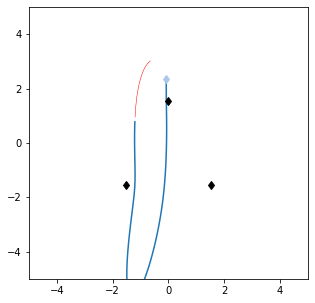

Charges are [-0.85727472 -0.52657655 -0.09680789]


In [143]:
test_idx = np.random.randint(150)
plot_example(simulation_train[test_idx], simulation_continued_train[test_idx])
print(f'Charges are {charges_train[test_idx]}')

# Task 3.1

## Data Handling and Preprocessing

In [144]:
train_tokenized = [(torch.tensor(simulation_train[i]), 
                    torch.tensor(charges_train[i])) 
                    for i in range(len(simulation_train))]
val_tokenized = [(torch.tensor(simulation_valid[i]), 
                    torch.tensor(charges_valid[i])) 
                    for i in range(len(simulation_valid))]
test_tokenized = [(torch.tensor(simulation_test[i]), 
                    torch.tensor(charges_test[i])) 
                    for i in range(len(simulation_test))]

In [145]:
# train_dataloader = DataLoader(train_tokenized, batch_size=1)
# val_dataloader = DataLoader(val_tokenized, batch_size=1)
# test_dataloader = DataLoader(test_tokenized, batch_size=1)

In [146]:
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

def collate_batch(batch):
    """
    Concatenate multiple datapoints to obtain a single batch of data
    """
    # sentences are stored as tuples; get respective lists
    batch.sort(key=lambda x: len(x[0]), reverse=True)
    sim_list = [x[0] for x in batch]
    data_length = [len(x[0]) for x in batch]
    charge_list = [x[1] for x in batch]

    # pad sequences in batch
    sim_padded = pad_sequence(sequences = sim_list, 
                             batch_first = True, 
                             padding_value = 0)
    charge_padded = pad_sequence(sequences = charge_list, 
                             batch_first = True, 
                             padding_value = 0)
    return sim_padded, charge_padded, data_length




## Model Implementation

In [147]:
from torch import nn

class RNNClassificationModel(nn.Module):
    """ LSTM with embedding layer"""
    def __init__(self, embed_dim, n_layers, hidden_dim):
        super(RNNClassificationModel, self).__init__()
        
        # save some parameters
        self.n_layers = n_layers
        self.embed_dim = embed_dim

        self.input_embedding_layer = nn.Linear(2, self.embed_dim)
        
        self.rnn = nn.LSTM(embed_dim, hidden_dim, n_layers, batch_first=True)
        
        self.fc1 = nn.Linear(hidden_dim, hidden_dim)

        self.fc2 = nn.Linear(hidden_dim, 3)
        
        self.drop = nn.Dropout(p=0.5)
        
        self.criterion = nn.MSELoss()
        
        self.optimizer = torch.optim.Adam(self.parameters(),lr=1e-4)
        

    def forward(self, seq, seq_length):

        seq = seq.float() 
        h = self.input_embedding_layer(seq)

        packed_h = torch.nn.utils.rnn.pack_padded_sequence(h, seq_length, batch_first=True,enforce_sorted=False)
    
        # Feed packed input sequence to lstm 
        out, (hidden, _) = self.rnn(packed_h)
        
        # Original unpadded length
        unpacked, unpacked_len = torch.nn.utils.rnn.pad_packed_sequence(out, batch_first=True)
        # retrieve final hidden output of last timestep for each sequence
        # shape [batch_size, hidden_dim]
        indices = torch.LongTensor(np.array(unpacked_len) - 1).view(-1, 1).expand(unpacked.size(0), unpacked.size(2)).unsqueeze(1)
        last_timestep = unpacked.gather(dim=1, index=indices).squeeze(dim=1)
        
        # apply dropout
        last_timestep = self.drop(last_timestep)
        
        # feed lstm output to MLP, apply ReLU nonlinearity
        # shape [batch_size, hidden_dim]
        h = self.drop(self.fc1(last_timestep))
        h = nn.ReLU()(h)
        
        # shape [batch_size, num_classes]
        y_pred = self.fc2(h)
    
        return y_pred


In [148]:
from torch import nn

class RNNClassificationModel_bl1(nn.Module):
    """Baseline model 1: RNN with embedding layer"""
    def __init__(self, embed_dim, n_layers, hidden_dim):
        super(RNNClassificationModel_bl1, self).__init__()
        
        # save some parameters
        self.n_layers = n_layers

        self.embed_dim = embed_dim

        self.input_embedding_layer = nn.Linear(2, self.embed_dim)
        
        self.rnn = nn.RNN(embed_dim, hidden_dim, n_layers, batch_first=True)
        
        self.fc1 = nn.Linear(hidden_dim, hidden_dim)
   
        self.fc2 = nn.Linear(hidden_dim, 3)
        
        self.drop = nn.Dropout(p=0.5)
        
        self.criterion = nn.MSELoss()
        
        self.optimizer = torch.optim.Adam(self.parameters(),lr=1e-4)
        

    def forward(self, seq, seq_length):
        
        seq = seq.float() 
        h = self.input_embedding_layer(seq)

        packed_h = torch.nn.utils.rnn.pack_padded_sequence(h, seq_length, batch_first=True,enforce_sorted=False)
    
        # Feed packed input sequence to lstm 
        out, hidden = self.rnn(packed_h)
        
        # Original unpadded length
        unpacked, unpacked_len = torch.nn.utils.rnn.pad_packed_sequence(out, batch_first=True)
        indices = torch.LongTensor(np.array(unpacked_len) - 1).view(-1, 1).expand(unpacked.size(0), unpacked.size(2)).unsqueeze(1)
        last_timestep = unpacked.gather(dim=1, index=indices).squeeze(dim=1)
        
        # apply dropout
        last_timestep = self.drop(last_timestep)
        
        # feed lstm output to MLP, apply ReLU nonlinearity
        # shape [batch_size, hidden_dim]
        h = self.drop(self.fc1(last_timestep))
        h = nn.ReLU()(h)
        
        # shape [batch_size, num_classes]
        y_pred = self.fc2(h)
    
        return y_pred

In [149]:
from torch import nn

class RNNClassificationModel_bl2(nn.Module):
    """Baseline model 2: LSTM without embedding layer"""

    def __init__(self, embed_dim, n_layers, hidden_dim):
        super(RNNClassificationModel_bl2, self).__init__()
        
        # save some parameters
        self.n_layers = n_layers
        self.embed_dim = embed_dim

        #self.input_embedding_layer = nn.Linear(2, self.embed_dim)
        
        #self.word_embeddings = nn.Embedding(vocab_size, embed_dim)
        
        self.rnn = nn.LSTM(embed_dim, hidden_dim, n_layers, batch_first=True)
        
        self.fc1 = nn.Linear(hidden_dim, hidden_dim)
        #make output in [-1,0]
        self.fc2 = nn.Linear(hidden_dim, 3)
        
        self.drop = nn.Dropout(p=0.5)
        
        self.criterion = nn.MSELoss()
        
        self.optimizer = torch.optim.Adam(self.parameters(),lr=1e-4)
        

    def forward(self, seq, seq_length):
        
        # input shapes:
        # text: [batch_size, max. sequence length in batch]
        
        
        # embed sequences with word embedding
        # shape [batch_size, max. sequence length in batch, embed_dim]
        seq = seq.float() 
        h = seq

        packed_h = torch.nn.utils.rnn.pack_padded_sequence(h, seq_length, batch_first=True,enforce_sorted=False)
    
        # Feed packed input sequence to lstm 
        out, (hidden, _) = self.rnn(packed_h)
        
        # Original unpadded length
        unpacked, unpacked_len = torch.nn.utils.rnn.pad_packed_sequence(out, batch_first=True)
        # retrieve final hidden output of last timestep for each sequence
        # shape [batch_size, hidden_dim]
        indices = torch.LongTensor(np.array(unpacked_len) - 1).view(-1, 1).expand(unpacked.size(0), unpacked.size(2)).unsqueeze(1)
        last_timestep = unpacked.gather(dim=1, index=indices).squeeze(dim=1)
        
        # apply dropout
        last_timestep = self.drop(last_timestep)
        
        # feed lstm output to MLP, apply ReLU nonlinearity
        # shape [batch_size, hidden_dim]
        h = self.drop(self.fc1(last_timestep))
        h = nn.ReLU()(h)
        
        # shape [batch_size, num_classes]
        y_pred = self.fc2(h)
    
        return y_pred

## Model Training

In [150]:
model = RNNClassificationModel(embed_dim=64, 
                               n_layers = 1, 
                               hidden_dim=128)

In [151]:
model_bl1 = RNNClassificationModel_bl1(embed_dim=64, 
                               n_layers = 1, 
                               hidden_dim=128)

In [152]:
model_bl2 = RNNClassificationModel_bl2(embed_dim=2, 
                               n_layers = 1, 
                               hidden_dim=128)

In [153]:
import time
from torch.nn.functional import softmax

def train(model,dataloader):

    rmse_losses = []
    mse_losses = []
    
    model.train()
    
    total_acc, total_count = 0, 0
    start_time = time.time()
    for (batch_x, y_true, batch_len) in tqdm.tqdm(dataloader):
                
        model.optimizer.zero_grad()

        y_true = y_true.to(torch.float32)
        
        y_pred = model(batch_x,batch_len) #shape (batch_size, num_classes) 

        mse_loss = model.criterion(y_pred, y_true)
        mse_losses.append(mse_loss.item())
        rmse_loss = torch.sqrt(model.criterion(y_pred, y_true))

        rmse_losses.append(rmse_loss.item())
        
        mse_loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        
        model.optimizer.step()
  
    return mse_losses, rmse_losses

def evaluate(model,dataloader):
    
    rmse_losses = []
    mse_losses = []

    model.eval()
    total_acc, total_count = 0, 0

    with torch.no_grad():
        for idx, (batch_x, y_true, batch_len) in enumerate(dataloader):
            
            y_pred = model(batch_x,batch_len) #shape (batch_size, num_classes) 
            
            mse_loss = model.criterion(y_pred, y_true)
            mse_losses.append(mse_loss.item())
            rmse_loss = torch.sqrt(model.criterion(y_pred, y_true))

            rmse_losses.append(rmse_loss.item())

    return mse_losses, rmse_losses

In [154]:
EPOCHS = 2 #100 # epoch
BATCH_SIZE = 8

scheduler = torch.optim.lr_scheduler.StepLR(model.optimizer, step_size=20, gamma=0.1)

train_loss_mse, train_loss_rmse, val_loss_mse, val_loss_rmse = [], [], [], []
for epoch in range(1, EPOCHS + 1):
    epoch_start_time = time.time()
    
    train_dataloader = DataLoader(train_tokenized, batch_size=BATCH_SIZE, shuffle=True, 
                             collate_fn=collate_batch)
    val_dataloader = DataLoader(val_tokenized, batch_size=BATCH_SIZE, shuffle=True, 
                             collate_fn=collate_batch)
    # train_dataloader = DataLoader(train_tokenized, batch_size=BATCH_SIZE)
    # test_dataloader = DataLoader(test_tokenized, batch_size=BATCH_SIZE)
    
    train_loss_mse_epoch, train_loss_rmse_epoch = train(model, train_dataloader)
    train_loss_mse.append(train_loss_mse_epoch)
    train_loss_rmse.append(train_loss_rmse_epoch)
    val_loss_mse_epoch, val_loss_rmse_epoch = evaluate(model, val_dataloader)
    val_loss_mse.append(val_loss_mse_epoch)
    val_loss_rmse.append(val_loss_rmse_epoch)
    
    print('-' * 59)
    scheduler.step()
# store the average loss for every epoch during training 
train_loss_mean_mse, val_loss_mean_mse, train_loss_mean_rmse, val_loss_mean_rmse = [], [], [], []
for i in range(EPOCHS):
    train_loss_mean_mse.append(sum(train_loss_mse[i]) / len(train_loss_mse[i]))
    val_loss_mean_mse.append(sum(val_loss_mse[i]) / len(val_loss_mse[i]))
    train_loss_mean_rmse.append(sum(train_loss_rmse[i]) / len(train_loss_rmse[i]))
    val_loss_mean_rmse.append(sum(val_loss_rmse[i]) / len(val_loss_rmse[i]))

100%|██████████| 100/100 [00:11<00:00,  8.95it/s]


-----------------------------------------------------------


100%|██████████| 100/100 [00:11<00:00,  8.91it/s]


-----------------------------------------------------------


## Evaluation

In [155]:
def get_test_score_ind(model, dataloader):
    """"
    eveluate the performance of model on test set 
    get the index and loss of worst cases where the model fails
    and the best cases where the model show good performance
    """

    rmse_losses = []
    mse_losses = []

    model.eval()

    with torch.no_grad():
        for idx, (batch_x, y_true, batch_len) in enumerate(dataloader):
            
            y_pred = model(batch_x,batch_len) #shape (batch_size, num_classes) 
            
            mse_loss = model.criterion(y_pred, y_true)
            mse_losses.append(mse_loss.item())
            rmse_loss = torch.sqrt(model.criterion(y_pred, y_true))

            rmse_losses.append(rmse_loss.item())

            
    worst_inds= np.argpartition(mse_losses,-5)[-5:]
    best_inds= np.argpartition(mse_losses, 5)[:5]
    mse_score = sum(mse_losses) / len(mse_losses)
    rmse_score = sum(rmse_losses) / len(rmse_losses)
    return mse_score, rmse_score, mse_losses, rmse_losses, worst_inds, best_inds
test_dataloader = DataLoader(test_tokenized, batch_size=BATCH_SIZE, shuffle=True, 
                             collate_fn=collate_batch)
model = torch.load('model')
mse_score, rmse_score, mse_losses, rmse_losses, worst_inds, best_inds = get_test_score_ind(model, test_dataloader)

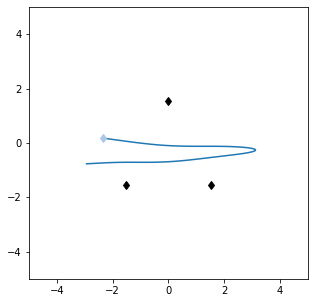

0.05699778745436468
Example with lowest loss: Charges are [-0.1375296  -0.05280612 -0.95305736]


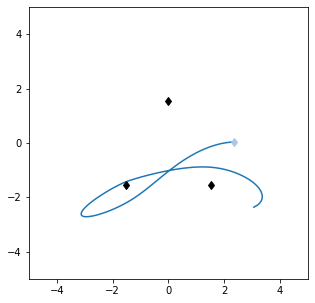

0.050555702725638356
Example with lowest loss: Charges are [-0.80701162 -0.35913297 -0.66586403]


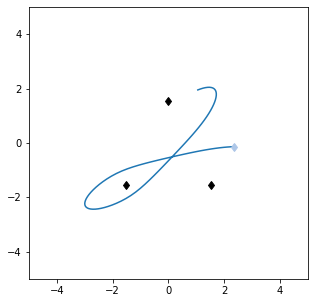

0.07314670455448742
Example with lowest loss: Charges are [-0.0918499  -0.35406486 -0.68168262]


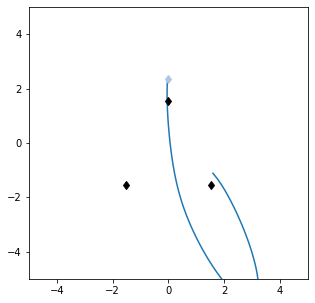

0.07265017385578211
Example with lowest loss: Charges are [-0.81015605 -0.67512385 -0.16594701]


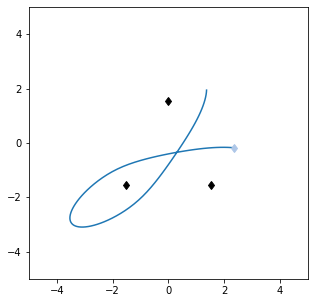

0.04082953500050829
Example with lowest loss: Charges are [-0.98451836 -0.1667747  -0.34789858]


In [156]:
""""show the best cases and their corresponding charges"""
for best_i in best_inds:
  plot_example(simulation_test[best_i])
  print(mse_losses[best_i])
  print(f'Example with lowest loss: Charges are {charges_train[best_i]}')

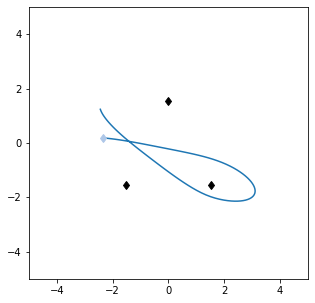

0.09945381565249169
Example with highest loss:Charges are [-0.99508806 -0.44820919 -0.2730329 ]


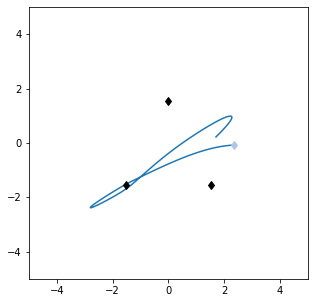

0.10169078757184886
Example with highest loss:Charges are [-0.36186577 -0.85073117 -0.15300605]


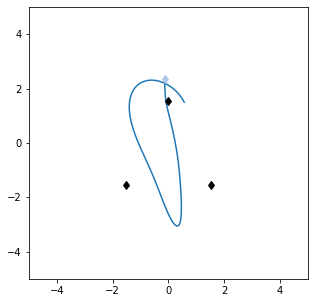

0.10319420640397277
Example with highest loss:Charges are [-0.48912768 -0.53956225 -0.53497113]


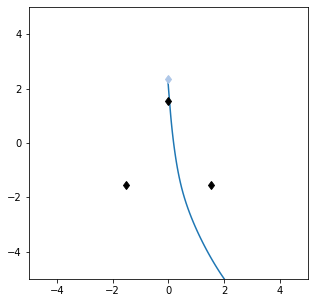

0.11343997556914044
Example with highest loss:Charges are [-0.37120766 -0.09868825 -0.31392034]


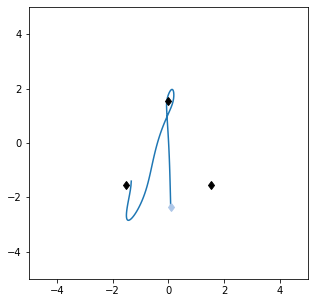

0.12416306575241609
Example with highest loss:Charges are [-0.4106839  -0.08464682 -0.99831876]


In [157]:
""""show the worst cases and their corresponding charges"""
for worst_i in worst_inds:
  plot_example(simulation_test[worst_i])
  print(mse_losses[worst_i])
  print(f'Example with highest loss:Charges are {charges_train[worst_i]}')

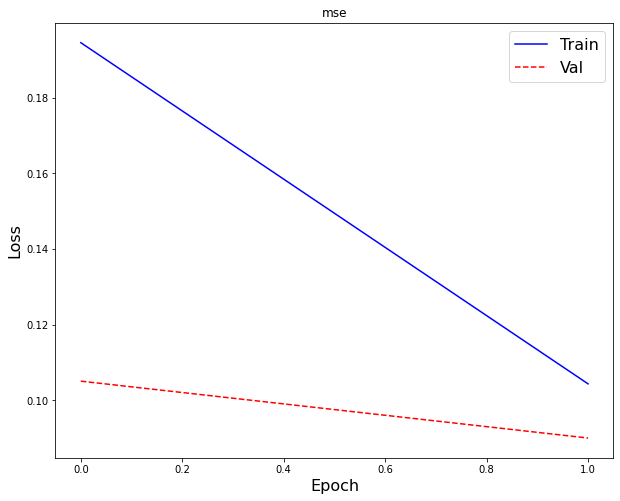

In [158]:
# plot the training loss and the validation loss during the training process
eval_meth = 'mse'
f, ax = plt.subplots(1,1, figsize=(10,8))

fnt=16
ax.plot(train_loss_mean_mse, color='blue', label='Train')
ax.plot(val_loss_mean_mse, color='red', linestyle='--', label='Val')
ax.legend(fontsize=fnt)
#ax.tick_params(axis='both', labelsize=fnt)
plt.title(eval_meth)
ax.set_xlabel("Epoch", fontsize=fnt)
ax.set_ylabel("Loss", fontsize=fnt);
#f.savefig(eval_meth+str(BATCH_SIZE)+'.jpg')

# Task 3.2

## Data Handling and Preprocessing

In [159]:
import torch
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
import numpy as np
from PIL import Image

class MyDataset(Dataset):
    def __init__(self, input_data, label_data):
        self.input_data = input_data
        self.label_data = label_data
        
    def __getitem__(self, index):
        input = self.input_data[index]
        label = self.label_data[index]
        return torch.FloatTensor(input), torch.FloatTensor(label)
        
    def __len__(self):
        return len(self.label_data)

In [160]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [161]:
train_dataset = MyDataset(simulation_train, simulation_continued_train)
# data loader
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1,pin_memory=True)
# print(train_loader[0])
for x, y in train_loader:
  print(x.size(), y.size())
  break
# for x, y in enumerate(train_loader):

torch.Size([1, 103, 2]) torch.Size([1, 54, 2])




## Model Implementation

In [162]:
import torch.nn as nn

class Encoder(nn.Module):
    def __init__(self, input_dim, hid_dim, n_layers, output_dim, dropout):
        super().__init__()
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        
        self.rnn = nn.GRU(input_size=input_dim, hidden_size=hid_dim, num_layers=n_layers, dropout = dropout, batch_first=True)
        self.linear = nn.Linear(hid_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        
        
    def forward(self, input):
        out, hidden = self.rnn(input)
        output = self.linear(out)
        
        return output, hidden

In [163]:
class Decoder(nn.Module):
    def __init__(self, input_dim, hid_dim, n_layers, output_dim, dropout):
        super().__init__()
        
        self.hid_dim = hid_dim
        self.n_layers = n_layers

        self.rnn = nn.GRU(input_dim, hid_dim, n_layers, dropout = dropout,batch_first=True)
        self.fc_out = nn.Linear(hid_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
    
        
    def forward(self, input, hidden):
        # pytorch expects a sequence, but we use batches with 1 element, i.e., sequence length 1
        input = input.unsqueeze(1)
        output, hidden = self.rnn(input, hidden)
        
        prediction = self.fc_out(output.squeeze(1))  # squeeze our 'sequence length 1' away
        #prediction = [batch size, output dim]      
        
        return prediction, hidden

In [164]:
import torch.optim as optim
import random

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
        ### Your code here ###
        # self.optimizer = torch.optim.SGD(self.parameters(), lr=0.01, momentum=0.5)
        # self.optimizer = optim.Adam(self.parameters(),lr=0.005,weight_decay=0.01)
        # self.optimizer = optim.Adam(self.parameters(),weight_decay=0.0001)
        # self.optimizer = torch.optim.SGD(self.parameters(), lr=0.25, momentum=0.5)
        self.optimizer = optim.Adam(self.parameters(),lr = 1e-3, weight_decay=0)
        self.criterion = nn.L1Loss()
        

    def forward(self, src, trg, teacher_forcing_ratio = 0):
        """
        Forward pass of the seq2seq model. It encodes the source sentence into
        a dense representation and thereafter transduces into the target
        sentence.
        
        Inputs:
        src: 
        trg:  
        teacher_forcing_ratio: probability to use teacher forcing, e.g. 0.5 we use ground-truth target sentence 50% of the time
        
        Outputs:
        outputs: index representation of the predicted positions with shape [batch_size, trg_len, element_size]
        """
        batch_size = trg.shape[0]
        trg_len = trg.shape[1]
        element_size = trg.shape[2]

        #tensor to store decoder outputs
        outputs = torch.zeros(batch_size, trg_len, element_size).to(self.device)
        #last hidden state of the encoder is used as the initial hidden state of the decoder
        output, hidden = self.encoder(src)
        
        # first input to the decoder is the <sos> tokens
        input = output[:, -1, :].clone()
        outputs[:,0,:] = input
        for t in range(1, trg_len):
            output, hidden= self.decoder(input, hidden)

            #place predictions in a tensor holding predictions for each time point
            outputs[:,t,:] = output.squeeze(1)
            
            #decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio
            
            #if teacher forcing, use actual next positions as next input
            #if not, use predicted positions
            input = trg[:,t,:].clone() if teacher_force else outputs[:,t,:].clone()

        return outputs


## Model Training

In [165]:
BATCH_SIZE = 1
N_EPOCHS = 2 #50
DROPOUT = 0.5
N_LAYERS = 4 #paper uses 4
HIDDEN_DIM = 64 #dimension of the lstm's hidden state
INPUT_DIM = 2
OUTPUT_DIM = 2

In [166]:
from torch.optim import optimizer
# initiate seq2seq translation model
enc = Encoder(INPUT_DIM, HIDDEN_DIM, N_LAYERS, OUTPUT_DIM, DROPOUT)
dec = Decoder(INPUT_DIM, HIDDEN_DIM, N_LAYERS, OUTPUT_DIM, DROPOUT)

seq2seq = Seq2Seq(enc, dec, device).to(device)
train_dataset = MyDataset(simulation_train, simulation_continued_train)
valid_dataset = MyDataset(simulation_valid, simulation_continued_valid)
# data loader
# train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=10, collate_fn=collate_batch)
# print(train_loader[0])

In [167]:
def baseline_predict(src_arr,trg_arr):
  last_pos =src_arr[-1]
  second_last_pos = src_arr[-2]
  pos_diff = second_last_pos-last_pos

  trg_len = len(trg_arr)
  predictions = []
  for i in range(trg_len):
    if i==0:
      current_pos = last_pos
    current_pos = last_pos+pos_diff
    predictions.append(current_pos)
  
  return np.array(predictions)

In [168]:
from numpy.linalg import norm

def get_score(output,baseline,targets):
  # print("output")
  # print(output.shape)
  # print("target")
  # print(targets.shape)
  cos_sim = np.sum(output*targets, axis=1)/(norm(output, axis=1)*norm(targets, axis=1))
  # return a list of similarities corresponds to the number of output time points
  # print("cosine_sim")
  # print(cos_sim.shape)

  out_trg_dist = np.linalg.norm(output-targets)
  base_trg_dist = np.linalg.norm(baseline-targets)
  ratio = out_trg_dist / base_trg_dist

  return np.mean(cos_sim), ratio

In [169]:
import time
from tqdm import tqdm
from torch.utils.data.dataloader import default_collate
from sklearn.metrics import r2_score


def train(dataset):
    epoch_loss = 0
    seq2seq.train()
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE,collate_fn=lambda x: tuple(x_.to(device) for x_ in default_collate(x)))
    sim_scores=[]
    comparison_scores = []

    ### Your code here ###
    for i, (src, trg) in enumerate(tqdm(dataloader)):
        seq2seq.optimizer.zero_grad()
        output = seq2seq(src, trg)
        
        loss = seq2seq.criterion(output, trg)
        
        loss.backward() # inputs=list(seq2seq.parameters())
        
        # torch.nn.utils.clip_grad_norm_(seq2seq.parameters(), clip)
        
        seq2seq.optimizer.step()
        
        epoch_loss += loss.item()
        
        if device == torch.device("cuda"):
          torch.cuda.empty_cache()
        
        # print(output.cpu().detach().numpy()[0])
        # calculate r2 score (use [0] to reduce the dimension of the 3d numpy array to 2d)

        # evaluation based on the baseline
        src_arr = src.cpu().detach().numpy()[0] # (sequence length, two positions)
        trg_arr = trg.cpu().detach().numpy()[0]
        baseline = baseline_predict(src_arr,trg_arr)
        cos_sim,comparison_score = get_score(output.cpu().detach().numpy()[0],baseline,trg_arr)
        sim_scores.append(cos_sim)
        comparison_scores.append(comparison_score)
    
    avg_sim_score = np.mean(sim_scores)
    avg_comp_score = np.mean(comparison_scores)
    return avg_sim_score, avg_comp_score, epoch_loss / len(dataloader)

def evaluate(dataset):
    epoch_loss = 0
    seq2seq.eval()
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE,collate_fn=lambda x: tuple(x_.to(device) for x_ in default_collate(x)))
    sim_scores=[]
    comparison_scores = []
    with torch.no_grad():

        for i, (src, trg) in enumerate(dataloader):

            output = seq2seq(src, trg, 0) #turn off teacher forcing

            loss = seq2seq.criterion(output, trg)
            
            epoch_loss += loss.item()

            # evaluation based on the baseline
            src_arr = src.cpu().detach().numpy()[0] # (sequence length, two positions)
            trg_arr = trg.cpu().detach().numpy()[0]
            baseline = baseline_predict(src_arr,trg_arr)
            sim_score,comp_score = get_score(output.cpu().detach().numpy()[0],baseline,trg_arr)
            sim_scores.append(sim_score)
            comparison_scores.append(comp_score)
            
            if device == torch.device("cuda"):
              torch.cuda.empty_cache()

        avg_sim_score = np.mean(sim_scores)
        avg_comp_score = np.mean(comparison_scores)
    
    return avg_sim_score, avg_comp_score, epoch_loss / len(dataloader)


best_valid_loss = float('inf')
train_loss_list = []; 
val_loss_list = [];
train_sim_scores,val_sim_scores,train_comp_scores,val_comp_scores=[],[],[],[]

for epoch in range(N_EPOCHS):
    
    epoch_start_time = time.time()

    train_sim_score,train_comp_score,train_loss = train(train_dataset)
    val_sim_score,val_comp_score,val_loss = evaluate(valid_dataset)
    train_sim_scores.append(train_sim_score)
    val_sim_scores.append(val_sim_score)
    train_comp_scores.append(train_comp_score)
    val_comp_scores.append(val_comp_score)
    
    train_loss_list.append(train_loss)
    val_loss_list.append(val_loss)
    
    if val_loss < best_valid_loss:
        best_val_loss = val_loss
        torch.save(seq2seq.state_dict(), 'p3_3-model.pt')
    
    print('-' * 76)
    print('| end of epoch {:3d} | time: {:5.2f}s | '
          'train loss {:8.3f} '
          'valid loss {:8.3f} '.format(epoch,
                                           time.time() - epoch_start_time, 
                                           train_loss_list[-1],
                                           val_loss_list[-1]))
    print('-' * 76)


100%|██████████| 150/150 [00:09<00:00, 15.18it/s]


----------------------------------------------------------------------------
| end of epoch   0 | time: 11.39s | train loss    1.363 valid loss    1.352 
----------------------------------------------------------------------------


100%|██████████| 150/150 [00:09<00:00, 15.27it/s]


----------------------------------------------------------------------------
| end of epoch   1 | time: 11.31s | train loss    1.219 valid loss    1.433 
----------------------------------------------------------------------------


## Evaluation

In [170]:
def loss_evaluate(dataset):
    epoch_loss = 0
    seq2seq.eval()
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE,collate_fn=lambda x: tuple(x_.to(device) for x_ in default_collate(x)))
    baseline_losses = []
    nn_losses = []
    with torch.no_grad():

        for i, (src, trg) in enumerate(dataloader):

            output = seq2seq(src, trg, 0) #turn off teacher forcing

            loss = seq2seq.criterion(output, trg)
            nn_losses.append(loss)
            
            epoch_loss += loss.item()

            # evaluation based on the baseline
            src_arr = src.cpu().detach().numpy()[0] # (sequence length, two positions)
            trg_arr = trg.cpu().detach().numpy()[0]
            baseline = baseline_predict(src_arr,trg_arr)
            # print(baseline.shape)
            baseline_tensor = torch.from_numpy(baseline).to(device)
            trg_squeeze=torch.squeeze(trg,0)
            # baseline_tensor
            # trg_squeeze.to(device)
            baseline_loss = seq2seq.criterion(baseline_tensor, trg_squeeze)
            # print("~~~~~~~~~~~~~~~~~~~~~~~~")
            baseline_losses.append(baseline_loss)
            
            if device == torch.device("cuda"):
              torch.cuda.empty_cache()

        baseline_loss_mean = torch.mean(torch.stack(baseline_losses))
        # baseline_loss_mean = torch.mean(baseline_loss)
        nn_loss_mean = torch.mean(torch.stack(nn_losses))
    return baseline_loss_mean, nn_loss_mean

In [171]:
test_dataset = MyDataset(simulation_test, simulation_continued_test)
test_sim_score,test_comp_score,test_loss = evaluate(test_dataset)

In [172]:
baseline_loss_mean, nn_loss_mean = loss_evaluate(test_dataset)

In [173]:
print(baseline_loss_mean)
print(nn_loss_mean)

tensor(1.3877, device='cuda:0')
tensor(1.4080, device='cuda:0')


In [174]:
print(test_comp_score)

1.19497


Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['f', 'random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


Text(0, 0.5, 'Loss')

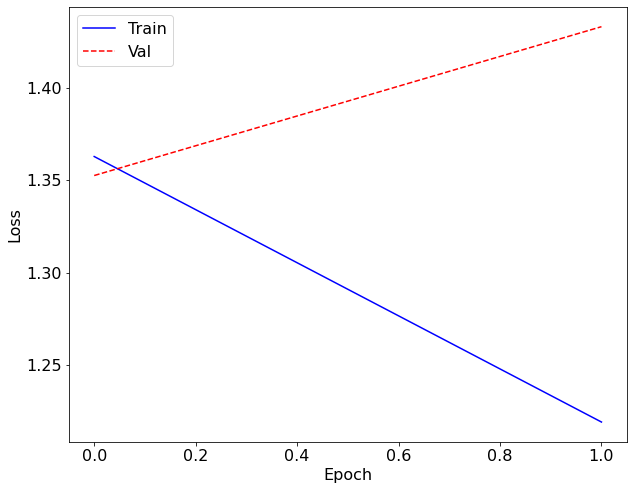

In [175]:
### Plot the training/validation accuracy vs. epochs ###
%pylab inline
import matplotlib.pyplot as plt

f, ax = plt.subplots(1, 1, figsize=(10,8))

fnt=16
ax.plot(train_loss_list, color='blue', label='Train')
ax.plot(val_loss_list, color='red', linestyle='--', label='Val')
ax.legend(fontsize=fnt)
ax.tick_params(axis='both', labelsize=fnt)

ax.set_xlabel("Epoch", fontsize=fnt)
ax.set_ylabel("Loss", fontsize=fnt)

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


Text(0, 0.5, 'Cosine similarity')

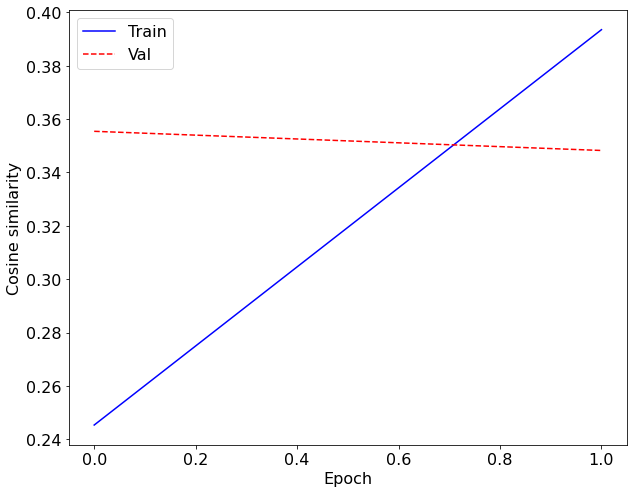

In [176]:

### Plot the training/validation accuracy vs. epochs ###
%pylab inline
import matplotlib.pyplot as plt

f, ax = plt.subplots(1, 1, figsize=(10,8))

fnt=16
ax.plot(train_sim_scores, color='blue', label='Train')
ax.plot(val_sim_scores, color='red', linestyle='--', label='Val')
ax.legend(fontsize=fnt)
ax.tick_params(axis='both', labelsize=fnt)

ax.set_xlabel("Epoch", fontsize=fnt)
ax.set_ylabel("Cosine similarity", fontsize=fnt)

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


Text(0, 0.5, 'Comparison scores')

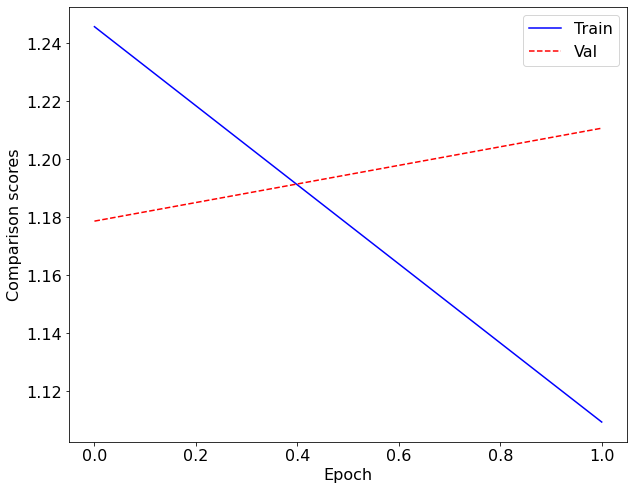

In [177]:
### Plot the training/validation accuracy vs. epochs ###
%pylab inline
import matplotlib.pyplot as plt

f, ax = plt.subplots(1, 1, figsize=(10,8))

fnt=16
ax.plot(train_comp_scores, color='blue', label='Train')
ax.plot(val_comp_scores, color='red', linestyle='--', label='Val')
ax.legend(fontsize=fnt)
ax.tick_params(axis='both', labelsize=fnt)

ax.set_xlabel("Epoch", fontsize=fnt)
ax.set_ylabel("Comparison scores", fontsize=fnt)

In [178]:
def get_test_inds(dataset):
    seq2seq.eval()
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE,collate_fn=lambda x: tuple(x_.to(device) for x_ in default_collate(x)))
    loss_history = []
    with torch.no_grad():

        for i, (src, trg) in enumerate(dataloader):

            output = seq2seq(src, trg, 0) #turn off teacher forcing

            loss = seq2seq.criterion(output, trg)

            loss_history.append(loss.cpu())
            
            if device == torch.device("cuda"):
              torch.cuda.empty_cache()
    worst_inds= np.argpartition(loss_history,-5)[-5:]
    best_inds= np.argpartition(loss_history, 5)[:5]
    
    return best_inds,worst_inds

In [179]:
test_dataset = MyDataset(simulation_test, simulation_continued_test)
best_inds,worst_inds = get_test_inds(test_dataset)

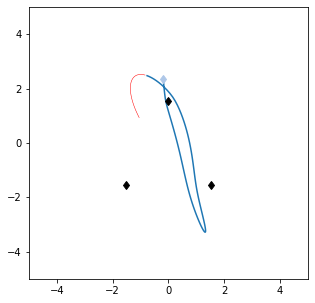

Example with lowest loss: Charges are [-0.01904122 -0.20077435 -0.36067369]


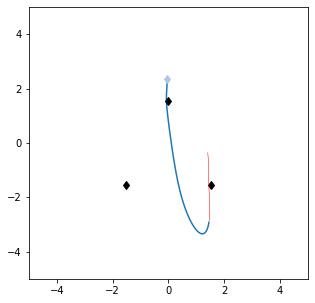

Example with lowest loss: Charges are [-0.1399828  -0.60077349 -0.94377978]


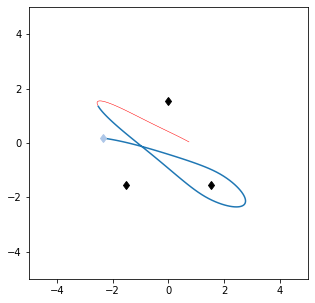

Example with lowest loss: Charges are [-0.19566214 -0.50865248 -0.61905666]


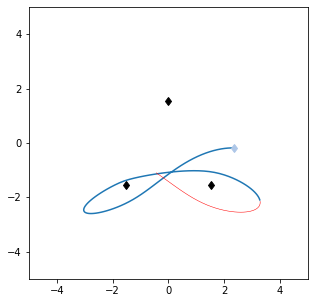

Example with lowest loss: Charges are [-0.52714657 -0.93753794 -0.78466797]


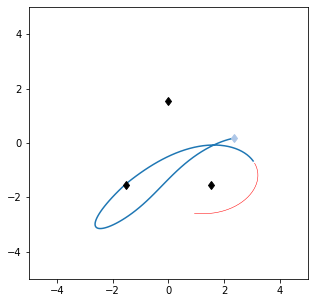

Example with lowest loss: Charges are [-0.35424691 -0.55251781 -0.59553632]


In [180]:
for best_i in best_inds:
  plot_example(simulation_test[best_i], simulation_continued_test[best_i])
  print(f'Example with lowest loss: Charges are {charges_train[best_i]}')

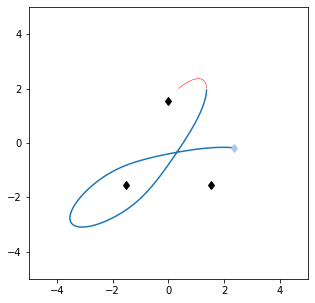

Example with highest loss:Charges are [-0.98451836 -0.1667747  -0.34789858]


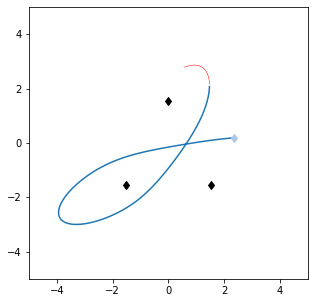

Example with highest loss:Charges are [-0.9355202  -0.96350592 -0.81551009]


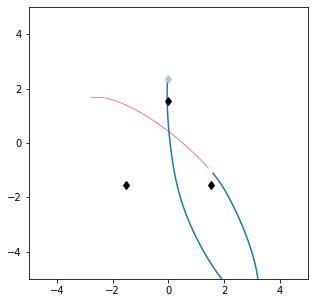

Example with highest loss:Charges are [-0.81015605 -0.67512385 -0.16594701]


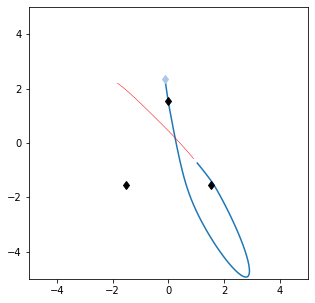

Example with highest loss:Charges are [-0.27367139 -0.9003474  -0.82114085]


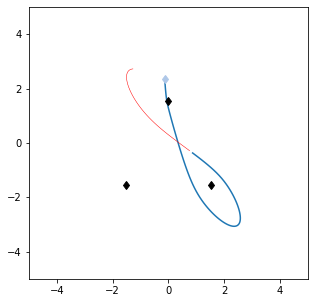

Example with highest loss:Charges are [-0.9614639  -0.92906296 -0.52035079]


In [181]:
for worst_i in worst_inds:
  plot_example(simulation_test[worst_i], simulation_continued_test[worst_i])
  print(f'Example with highest loss:Charges are {charges_train[worst_i]}')